In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from collections import Counter

import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import SVI, Trace_ELBO, Predictive, NUTS, MCMC

rng_np = np.random.default_rng(111)

n_factors_exposure = 10
n_factors_outcome = 10
K = 5

numpyro.set_platform('cpu')
numpyro.set_host_device_count(n=5)

# MovieLens data


In [2]:
names = ['userId', 'movieId', 'rating', 'timestamp']
df_ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df_ratings = df_ratings.drop('timestamp', axis=1)
print(df_ratings.shape)
df_ratings.head(3)


(100000, 3)


,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1


train-test split

In [3]:
# Taken from https://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html

# Define a function for splitting train/test data.
def split_train_test(data, percent_test, rng):
    """Split the data into train/test sets."""
    n, m = data.shape             # # users, # movies
    N = n * m                     # # cells in matrix
    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan
    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))   # tuples of row/col index pairs
    test_size = int(len(idx_pairs) * percent_test)  # use a % of data as test set
    train_size = len(idx_pairs) - test_size   # and remainder for training
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = rng.choice(indices, replace=False, size=test_size)
    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set
    # Verify everything worked properly
    assert(train_size == N-np.isnan(train).sum())
    assert(test_size == N-np.isnan(test).sum())
    # Return train set and test set
    return train, test


all_users = np.sort(df_ratings.userId.unique())
all_movies = np.sort(df_ratings.movieId.unique())
df_dense_data = df_ratings.pivot_table(index='userId', columns='movieId', values='rating')
assert all(df_dense_data.columns == all_movies)
assert all(df_dense_data.index == all_users)

n_users, n_items = all_users.shape[0], all_movies.shape[0]
train, test = split_train_test(df_dense_data.values, 0.2, rng=rng_np)

print(train.shape, test.shape)

(943, 1682) (943, 1682)


# Exposure model

In [4]:
exposure_train = jnp.nan_to_num(train, nan=0)
exposure_train = jnp.where(exposure_train > 0, 1, 0)
print(exposure_train.shape)
print(exposure_train.mean(), exposure_train.sum(), jnp.count_nonzero(exposure_train))

(943, 1682)
0.050437354 80000 80000


In [5]:
def exposure_model(n_users: int, n_items: int, n_factors: int, exposure=None):
    """Hierarchical Poisson factorization model."""
    plate_users = numpyro.plate('plate_users', n_users, dim=-1)
    plate_items = numpyro.plate('plate_items', n_items, dim=-1)
    c = 5  # 10
    r = 1  # 3
    with plate_users:
        activity = numpyro.sample('activity', dist.Gamma(c, r))
        preferences = numpyro.sample('preferences', dist.Gamma(0.3, activity), sample_shape=(n_factors,))
    with plate_items:
        popularity = numpyro.sample('popularity', dist.Gamma(c, r))
        attributes = numpyro.sample('attributes', dist.Gamma(0.3, popularity), sample_shape=(n_factors,))
    rates = numpyro.deterministic('rates', preferences.T @ attributes)
    obs = numpyro.sample('obs', dist.Poisson(rates), obs=exposure)
    return obs



def hpf_guide(n_users: int, n_items: int, n_factors: int, exposure):
    """hierarchical Poisson factorization guide."""
    plate_users = numpyro.plate('plate_users', n_users, dim=-1)
    plate_items = numpyro.plate('plate_items', n_items, dim=-1)
    with plate_items:
        popularity_concentration = numpyro.param(
            'popularity_concentration',
            5 * jnp.ones(shape=(n_items,)),
            constraint=constraints.positive
        )
        popularity_rate = numpyro.param(
            'popularity_rate',
            1 * jnp.ones(shape=(n_items,)),
            constraint=constraints.positive
        )
        popularity = numpyro.sample(
            'popularity', dist.Gamma(popularity_concentration, popularity_rate)
        )
        attributes_concentration = numpyro.param(
            'attributes_concentration',
            0.3 * jnp.ones(shape=(n_items,)),
            constraint=constraints.positive
        )
        attributes = numpyro.sample(
            'attributes', 
            dist.Gamma(attributes_concentration, popularity), 
            sample_shape=(n_factors,)
        )
    with plate_users:
        activity_concentration = numpyro.param(
            'activity_concentration',
            5 * jnp.ones(shape=(n_users,)),
            constraint=constraints.positive
        )
        activity_rate = numpyro.param(
            'activity_rate',
            1 * jnp.ones(shape=(n_users,)),
            constraint=constraints.positive
        )
        activity = numpyro.sample(
            'activity', dist.Gamma(activity_concentration, activity_rate)
        )
        preferences_concentration = numpyro.param(
            'preferences_concentration',
            0.3 * jnp.ones(shape=(n_users,)),
            constraint=constraints.positive
        )
        preferences = numpyro.sample(
            'preferences', 
            dist.Gamma(preferences_concentration, activity), 
            sample_shape=(n_factors,)
        )


with numpyro.handlers.seed(rng_seed=1234):
    prior_sample = exposure_model(n_users, n_items, n_factors_exposure)
    print(prior_sample.shape)
    print(prior_sample.mean(), prior_sample.sum(), jnp.count_nonzero(prior_sample), prior_sample.max())
    hpf_guide(n_users, n_items, n_factors_exposure, exposure_train)


(943, 1682)
0.10843464 171991 147510 25


final loss: 273203.78125


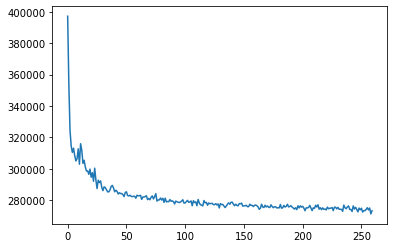

In [26]:
# SVI
n_iters = 260
step_size = 0.1
optimizer = numpyro.optim.Adam(step_size=step_size)
svi = SVI(exposure_model, hpf_guide, optimizer, loss=Trace_ELBO(num_particles=1))

init_state = svi.init(
    random.PRNGKey(55), 
    n_users, n_items, n_factors_exposure, exposure_train
)

state, losses = jax.lax.scan(
    lambda state, i: svi.update(state, n_users, n_items, n_factors_exposure, exposure_train), 
    init_state, jnp.arange(n_iters)
)
print(f'final loss: {losses[-1]}')
svi_params = svi.get_params(svi_state=state)
plt.plot(losses);

In [8]:
# # MCMC
# rng_key = random.PRNGKey(1234)
# nuts_kernel = NUTS(hpf_model)
# mcmc = MCMC(nuts_kernel, num_samples=200, num_warmup=1000, num_chains=1)
# mcmc.run(rng_key, n_users, n_items, n_factors_exposure, exposure_train)
# posterior_samples = mcmc.get_samples()

# for k, a in posterior_samples.items():
#     print(k, a.shape)
#     jnp.save(f'./exposure_samples/{k}.npy', a)


### Posterior predictive checks

In [7]:
# MCMC rates
# rates = np.load('./exposure_samples/rates.npy')
# print(rates.shape)

(200, 943, 1682)


In [27]:
# SVI rates
post_predictive = Predictive(
    exposure_model, guide=hpf_guide, params=svi_params, num_samples=200,
    return_sites=['rates']
)
posterior = post_predictive(
    random.PRNGKey(90),
    n_users, n_items, n_factors_exposure, exposure_train
)
rates = posterior['rates']
print(rates.shape)

(200, 943, 1682)


In [28]:
posterior_samples = rng_np.poisson(rates)
posterior_samples.shape

(200, 943, 1682)

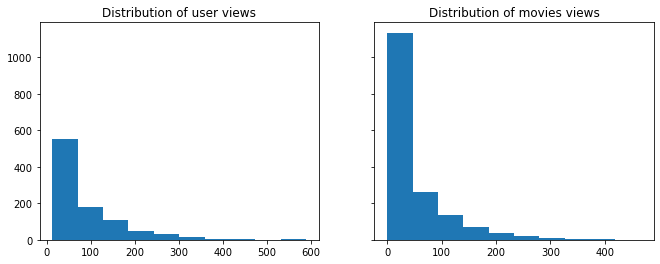

In [33]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 4), sharey=True)
_, bins_user, _ = axs[0].hist(exposure_train.sum(axis=1), bins=10)
axs[0].set(title='Distribution of user views');
_, bins_movie, _ = axs[1].hist(exposure_train.sum(axis=0), bins=10)
axs[1].set(title='Distribution of movies views');

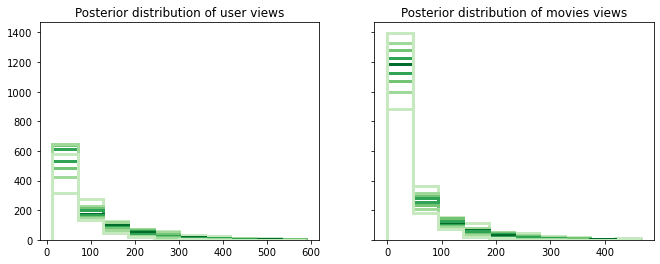

In [34]:
colors = [
    '#c7e9c0','#a1d99b','#74c476','#31a354', '#006d2c',
    '#31a354','#74c476','#a1d99b','#c7e9c0',
]
quantiles = np.arange(0.1, 1, 0.1)

user_views_quantiles = np.quantile(posterior_samples.sum(axis=2), q=quantiles, axis=0)
movie_views_quantiles = np.quantile(posterior_samples.sum(axis=1), q=quantiles, axis=0)

fig, axs = plt.subplots(ncols=2, figsize=(11, 4), sharey=True)
axs[0].hist(
    user_views_quantiles.T, histtype='step', color=colors, linewidth=3, bins=bins_user
)
axs[0].set(title='Posterior distribution of user views');
axs[1].hist(
    movie_views_quantiles.T, histtype='step', color=colors, linewidth=3, bins=bins_movie
)
axs[1].set(title='Posterior distribution of movies views');

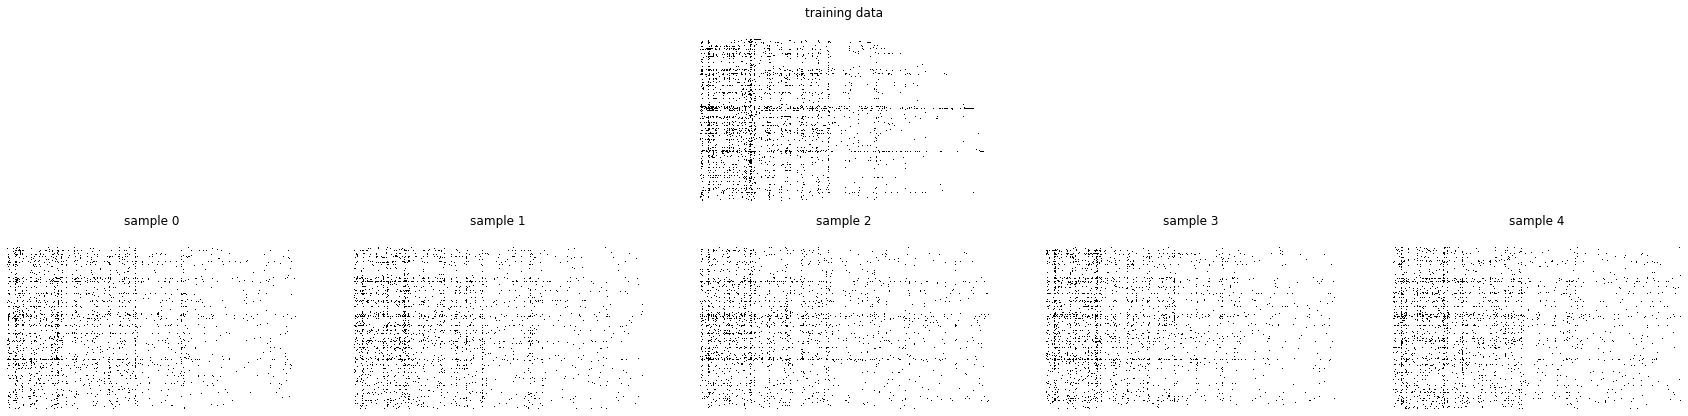

In [35]:
fig = plt.figure(figsize=(30, 7))
axs = fig.subplot_mosaic(
    '''
    ..O..
    ABCDE
    '''
)
# training data
axs['O'].spy(exposure_train)
axs['O'].set(title='training data')
axs['O'].set_axis_off()
# samples from the posterior
ids = rng_np.integers(0, posterior_samples.shape[0], size=5)
for k, i in zip('ABCDE', range(0, 5)):
    axs[k].spy(posterior_samples[i, ...])
    axs[k].set(title=f'sample {i}')
    axs[k].set_axis_off()


#### TODO: 
* Measure predictive power using the median value of the rates
* Prior predictive checks and parameter recovery
* EDA confounders

Counter({5.0: 16979, 3.0: 21768, 4.0: 27331, 1.0: 4892, 2.0: 9030})

# Outcome model

* HPF vs PMF ?
* Posterior predictive checks?
*

In [5]:
# expected value of the rates
confounders = jnp.load('./exposure_samples/rates.npy').mean(axis=0)
print(confounders.shape)

(943, 1682)


In [6]:
n_factors_outcome = 10

In [10]:
def outcome_model(
        n_users: int,
        n_items: int,
        n_factors: int,
        exposure,
        confounders,
        ratings=None
):
    plate_users = numpyro.plate('plate_users', n_users, dim=-1)
    plate_items = numpyro.plate('plate_items', n_items, dim=-1)
    c = 5  # 10
    r = 1  # 3
    with plate_users:
        activity = numpyro.sample('activity', dist.Gamma(c, r))
        preferences = numpyro.sample('preferences', dist.Gamma(0.3, activity), sample_shape=(n_factors,))
    with plate_items:
        popularity = numpyro.sample('popularity', dist.Gamma(c, r))
        attributes = numpyro.sample('attributes', dist.Gamma(0.3, popularity), sample_shape=(n_factors,))
    gammas = numpyro.sample('gammas', dist.Normal(0., 1), sample_shape=(n_users, 1))
    beta_0 = numpyro.sample('beta_0', dist.Normal(0., 1))
    mean = numpyro.deterministic(
        'mean',
        (preferences.T @ attributes) * exposure + (gammas * confounders) + beta_0
    )
    # mean can not be negative
    print(mean.min(), mean.max())
    # TODO: check missing values
    obs = numpyro.sample('obs', dist.Poisson(mean), obs=ratings)
    return obs


with numpyro.handlers.seed(rng_seed=101):
    prior_sample = outcome_model(n_users, n_items, n_factors_outcome, exposure_train, confounders)
    print(prior_sample.shape)
    # TODO: reduce max val
    print(prior_sample.max())

-4.5430427 9.2053585
(943, 1682)
10


In [9]:
print(Counter(train[~np.isnan(train)]))
print(Counter(prior_sample.flatten()))

Counter({4.0: 27331, 3.0: 21768, 5.0: 16979, 2.0: 9030, 1.0: 4892})
Counter({0: 1111394, 1: 377151, 2: 67712, -1: 19669, 3: 8871, 4: 1110, 5: 171, 6: 39, 7: 6, 9: 1, 10: 1, 8: 1})


In [ ]:
train_no_nan = jnp.nan_to_num(train, nan=0)
print(train_no_nan.shape)

scaled_ratings = (train - 1) / (K - 1)
# pd.Series(scaled_ratings.flatten()).plot.hist()
scaled_ratings = jnp.nan_to_num(scaled_ratings, nan=0)
print(scaled_ratings.shape)
# scaled_ratings
exposure_train = jnp.nan_to_num(train, nan=0)
exposure_train = jnp.where(exposure_train > 0, 1, 0)
print(exposure_train.shape)
exposure_train

In [ ]:
def pmf_model(exposure, confounders, ratings, n_factors: int, **kwargs):
    n_users, n_items = exposure.shape
    s = 0.1
    U = numpyro.sample('U', dist.Normal(0., s), sample_shape=(n_users, n_factors))
    V = numpyro.sample('V', dist.Normal(0., s), sample_shape=(n_items, n_factors))
    gammas = numpyro.sample('gammas', dist.Normal(0., 1), sample_shape=(n_users, 1))
    mean = (U @ V.T) * exposure + (gammas * confounders)
    mean = expit(mean)
    scale = jnp.ones_like(mean) * 0.001
    r = numpyro.sample('R', dist.Normal(mean, scale), obs=ratings)
    return mean


with numpyro.handlers.seed(rng_seed=101):
    res_model = pmf_model(exposure_train, confounders, scaled_ratings, n_factors_pmf)
    print(res_model.shape)
    print(res_model.min(), res_model.mean(), res_model.max())
res_model

In [ ]:
nuts_kernel = NUTS(pmf_model)
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=1000, num_chains=1)
rng_key = random.PRNGKey(15)
mcmc.run(rng_key, exposure_train, confounders, scaled_ratings, n_factors_pmf)
posterior_samples = mcmc.get_samples()

# Results

In [ ]:
# Functions taken from https://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html

def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~jnp.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = jnp.power(test_data - predicted, 2)
    mse = sqerror[I].sum() / N                 # mean squared error
    return jnp.sqrt(mse)


def mae(test_data, predicted):
    """Calculate Mean Absolute Error Ignoring missing values"""
    I = ~jnp.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    abserror = jnp.abs(test_data - predicted)
    mae = abserror[I].sum() / N   # mean squared error
    return mae

In [ ]:
def pmf_predict(U, V, gammas, confounders, k):
    mean = (U @ V.T) * 1. + (gammas * confounders)
    scaled_mean = expit(mean)
    preds = scaled_mean * (k - 1) + 1
    return preds

# samples
U_samples = jnp.load('./samples/U.npy')
V_samples = jnp.load('./samples/V.npy')
gammas_samples = jnp.load('./samples/gammas.npy')
beta_0_samples = jnp.load('./samples/beta_0.npy')

# params
U = np.median(U_samples, axis=0)
V = np.median(V_samples, axis=0)
gammas = np.median(gammas_samples, axis=0)
beta_0 = np.median(beta_0_samples, axis=0)

assert n_factors_pmf == U.shape[1]
assert n_factors_pmf == V.shape[1]

preds_pmf = pmf_predict(U, V, gammas, confounders, K)
print(preds_pmf.shape)

In [ ]:
print('RMSE:', rmse(test, preds_pmf))
print('MAE:', mae(test, preds_pmf))